In [1]:
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter 
from sklearn.linear_model import LinearRegression
from string import punctuation
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
df = pd.read_csv("cleaned.csv")
df.head()

corpus = list(df["description"])

In [3]:
def tokenize(desc):
    tokens = nltk.word_tokenize(desc)

    # filter out all tokens of length 1?
    return tokens

df["description"] = df["description"].apply(tokenize)

df.head()

,annual_salary,description
0,48880.0,"[many, industries, hurt, last, years, people, ..."
1,39500.0,"[Provide, clerical, administrative, support, m..."
2,100000.0,"[United, Staffing, Solutions, partnering, one,..."
3,38000.0,"[looking, responsible, Administrative, Assista..."
4,144000.0,"[REMOTE, WORK, HOME, COMMISSION, PER, ORDER, R..."


In [4]:
# for RNN it was recommended we use lengths of 50 tokens.
def lengths(desc):
    return len(desc)

df["len"] = df["description"].apply(lengths)

df.head()

,annual_salary,description,len
0,48880.0,"[many, industries, hurt, last, years, people, ...",170
1,39500.0,"[Provide, clerical, administrative, support, m...",62
2,100000.0,"[United, Staffing, Solutions, partnering, one,...",55
3,38000.0,"[looking, responsible, Administrative, Assista...",106
4,144000.0,"[REMOTE, WORK, HOME, COMMISSION, PER, ORDER, R...",96


<Axes: ylabel='Frequency'>

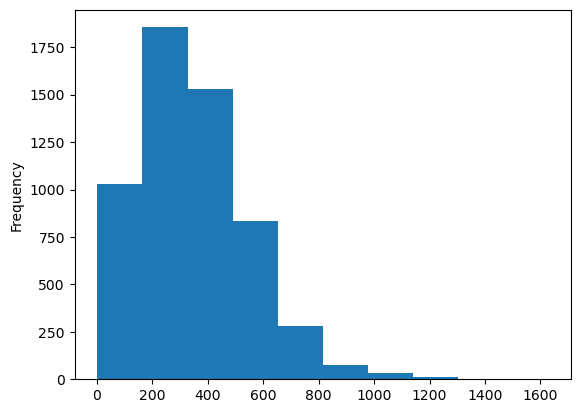

In [5]:
from collections import Counter

# print(Counter(df["len"]).keys())
# print(df.shape)

df["len"].plot.hist()


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer() 
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus) 
# print(tfidf_matrix.toarray())
# print(Counter(tfidf_matrix.toarray()[3]))

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, list(df["annual_salary"]))

print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))


model = LinearRegression()
model.fit(X_train, y_train)

model.coef_

# index = 9
# pred = model.predict([X_test[index]])

# print(y_test[index], pred[0])


(4240, 56824)
(1414, 56824)
4240
1414


array([    0.        , 11426.67819991, -3892.43236893, ...,
        4991.7777689 , -6036.60304855,  4991.7777689 ])

In [7]:
index = 1
pred = model.predict(X_test[index])

print(y_test[index], pred[0])

122500.0 132499.82364409644


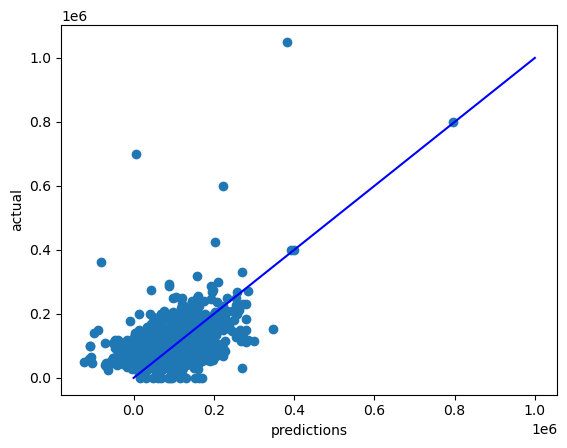

In [8]:
preds = model.predict(X_test)

#from sklearn.metrics import mean_squared_error 
#mean_squared_error(y_test, preds)
import matplotlib.pyplot as plt

# Sample data

# Create a scatter plot
plt.scatter(preds, y_test)

x = range(0, 1000000)
plt.plot(x, x, c="b")
# Add labels and title
plt.xlabel('predictions')
plt.ylabel('actual')

# Show the plot
plt.show()


# compare the actual and predicton in some way (ratio or subtraction)
# investigate the confusion matrix
# investigate the most "confused" items
# use coefficients from LR to reduce features for future models, and iterate 
# use tables to track parameters to the results from the models
# https://jalammar.github.io/explaining-transformers/

In [9]:
#bag of words
def featurize(vocab, tokenized_data):

    # use min_df or max_features?
    vectorizer = CountVectorizer(vocabulary=vocab, binary=False,max_features=200)

    data = []
    
    for text in tokenized_data:
        data.append(" ".join(text))

    X = vectorizer.fit_transform(data)

    return X.toarray(), vectorizer.get_feature_names_out()

featurized_data, count_vectorizer_vocab = featurize(None, list(df["description"]))


print(len(count_vectorizer_vocab))

200


In [10]:
X_train, X_test, y_train, y_test = train_test_split(featurized_data, list(df["annual_salary"]))

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

4240
1414
4240
1414


In [11]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [12]:
index = 9
pred = model.predict([X_test[index]])

print(y_test[index], pred[0])

100000.0 66793.6904728369


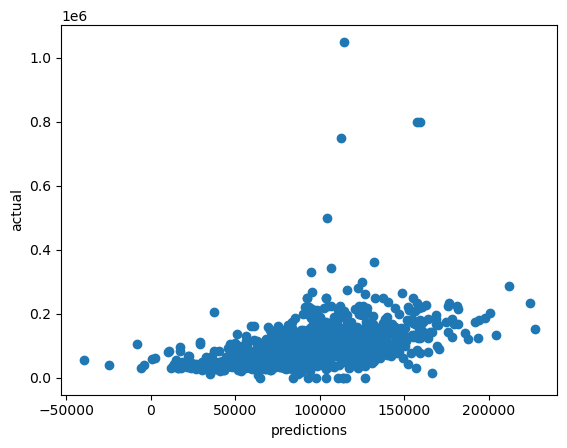

In [13]:
preds = model.predict(X_test)

#from sklearn.metrics import mean_squared_error 
#mean_squared_error(y_test, preds)
import matplotlib.pyplot as plt

# Sample data

# Create a scatter plot
plt.scatter(preds, y_test)

# Add labels and title
plt.xlabel('predictions')
plt.ylabel('actual')

# Show the plot
plt.show()

In [14]:
len(preds)

1414

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join the tokenized words in the 'description' column
df['description_joined'] = df['description'].apply(' '.join)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=20000)  # Adjust max_features based on your dataset
X = tfidf.fit_transform(df['description_joined']).toarray()
y = df['annual_salary'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Neural network architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(1))  # Single neuron for regression output

In [47]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
114/114 [==============================] - 4s 26ms/step - loss: 12619160576.0000 - mean_absolute_error: 93092.2422 - val_loss: 13546664960.0000 - val_mean_absolute_error: 94437.7578
Epoch 2/10
114/114 [==============================] - 3s 24ms/step - loss: 12612903936.0000 - mean_absolute_error: 93058.8672 - val_loss: 13537193984.0000 - val_mean_absolute_error: 94388.2188
Epoch 3/10
114/114 [==============================] - 3s 24ms/step - loss: 12600577024.0000 - mean_absolute_error: 92992.4688 - val_loss: 13521395712.0000 - val_mean_absolute_error: 94306.0859
Epoch 4/10
114/114 [==============================] - 3s 24ms/step - loss: 12581923840.0000 - mean_absolute_error: 92894.3047 - val_loss: 13499444224.0000 - val_mean_absolute_error: 94192.1172
Epoch 5/10
114/114 [==============================] - 3s 24ms/step - loss: 12557208576.0000 - mean_absolute_error: 92762.6953 - val_loss: 13471464448.0000 - val_mean_absolute_error: 94046.7734
Epoch 6/10
114/114 [===============

In [48]:
from sklearn.metrics import mean_absolute_error

# Predict on test data
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error
test_mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", test_mae)


36/36 [==============================] - 0s 3ms/step
Test MAE: 89807.07473012639
